<a href="https://colab.research.google.com/gist/WagnerMarcel/f92afc1877dcaf53da6880b58a785c0c/cvae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Conditional variational autoencoder
Variational autoencoder for tabular data, oriented upon: https://lschmiddey.github.io/fastpages_/2021/03/14/tabular-data-variational-autoencoder.html 

Adopted with one hot encoding for tabular data
## Load Json Database of recipes

In [1]:
from google.colab import drive
drive.mount('/content/drive')
dataPath = '/content/drive/MyDrive/TP2/Datasets/Recipe1M/2022_02_11/recipes_valid_0.pkl'
import sys
sys.path.append(dataPath)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
dataPath = 'data/recipes_valid_0.pkl'

In [2]:
import pickle
import pandas as pd

with open(dataPath, 'rb') as f:
    pklData = pd.DataFrame(pickle.load(f))

print(pklData.keys())
print(len(pklData))

Index(['title', 'ingredients', 'instructions'], dtype='object')
100000


## Convert list of ingredients to pandas dataframe and one hot encode the dataframe.

In [3]:
!pip install word2vec

In [3]:
from src.ReciMePreprocessor import ReciMePreprocessor

preprocessor = ReciMePreprocessor('data/vocab.bin')
#pklData = pklData[:2000]
out = preprocessor.preProcessInput(pklData['ingredients'])

## VAE
### Setup

In [4]:
# Import pytorch dependencies
import torch
from torch import optim
from torch.utils.data import DataLoader

# Import additional libraries
import pandas as pd
import numpy as np

# Import custom autoencoder
from src.ReciMeEncoder import ReciMeEncoder, RmeParameters
from src.ReciMeEncoder_unstacked import ReciMeEncoder_unstacked

# Import custom helper functions
from src.networkUtils import DataBuilder, standardize_data

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [5]:
import torch.nn as nn

class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()
        self.mse_loss = nn.MSELoss(reduction='none')
    
    def forward(self, x_recon, x, mu, logvar):
        loss_MSE = self.mse_loss(x_recon, x).sum(axis=1)
        loss_MSE = loss_MSE.mean()
        loss_KLD = -0.5 * torch.sum(1 + logvar - mu**2 - torch.exp(logvar), axis=1)
        loss_KLD = loss_KLD.mean()

        return loss_MSE, loss_KLD, loss_MSE + loss_KLD

In [37]:
loss = CustomLoss()

mat1 = torch.Tensor(np.zeros((1024,6400)))
mat2 = torch.Tensor(np.ones((1024,6400)))

mse, kld, l = loss(mat2, mat1, torch.tensor(np.zeros((1024,128))), torch.tensor(np.zeros((1024,128))))
mse.shape

torch.Size([1024, 6400])

### Setup Datasets + Hyperparameters

In [6]:
# One hot encoding without embedding and using sparse frame
train_data, test_data, scaler =  standardize_data(out)
batch_size = 1024
# Train/Testdataset split is defined in the DataBuilder
traindata_set=DataBuilder(train_data, standardizer=scaler)
testdata_set=DataBuilder(test_data, standardizer=scaler)
# Definition of batches
trainloader=DataLoader(dataset=traindata_set,batch_size=batch_size)
testloader=DataLoader(dataset=testdata_set,batch_size=batch_size)

In [26]:
params = RmeParameters(testdata_set.x.shape[1], 10000, 5000, 2500, 2500)

model = ReciMeEncoder_unstacked(params).to(device)
print(model)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_mse = CustomLoss()

### Train Model

In [27]:
epochs = 600
log_interval = 5
val_losses = []
train_losses = []
train_losses_MSE = []
train_losses_KLD = []
test_losses = []

In [28]:
def train_otherloss(epoch):
    model.train()
    for batch_idx, data in enumerate(trainloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss_MSE, loss_KLD, loss = loss_mse(recon_batch, data, mu, logvar)
        loss.backward()
        loss_itm = loss.item()
        train_loss = loss_itm
        train_loss_MSE = loss_MSE.item()
        train_loss_KLD = loss_KLD.item()
        train_losses.append(train_loss)
        train_losses_MSE.append(train_loss_MSE)
        train_losses_KLD.append(train_loss_KLD)
        optimizer.step()
    if epoch % log_interval == 0:        
        print('====> Epoch: {} Average training loss: {:.5f}, MSE: {:.5f}, KLD: {:.5f}'.format(
            epoch, train_loss, 
            train_loss_MSE , 
            train_loss_KLD))

In [29]:
def test_otherloss(epoch):
    with torch.no_grad():
        for batch_idx, data in enumerate(testloader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss_MSE, loss_KLD, loss = loss_mse(recon_batch, data, mu, logvar)
            loss_itm = loss.item()
            test_loss = loss_itm
            test_loss_MSE = loss_MSE
            test_loss_KLD = loss_KLD
            test_losses.append(test_loss)
        if epoch % log_interval == 0:        
            print('====> Epoch: {} Average training loss: {:.4f}, MSE: {:.4f}, KLD: {:.4f}'.format(
                epoch, test_loss, 
                test_loss_MSE, 
                test_loss_KLD))

In [30]:
def train(epoch):
    model.train()
    train_loss = 0
    train_loss_MSE = 0
    train_loss_KLD = 0
    for batch_idx, data in enumerate(trainloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss_MSE, loss_KLD, loss = loss_mse(recon_batch, data, mu, logvar)
        loss.backward()
        loss_itm = loss.item()
        train_loss += loss_itm
        train_loss_MSE += loss_MSE.item()
        train_loss_KLD += loss_KLD.item()
        optimizer.step()
    if epoch % log_interval == 0:        
        print('====> Epoch: {} Average training loss: {:.5f}, MSE: {:.5f}, KLD: {:.5f}'.format(
            epoch, train_loss / len(trainloader.dataset), 
            train_loss_MSE / len(trainloader.dataset), 
            train_loss_KLD / len(trainloader.dataset)))
        train_losses.append(train_loss / len(trainloader.dataset))
        train_losses_MSE.append(train_loss_MSE / len(trainloader.dataset))
        train_losses_KLD.append(train_loss_KLD / len(trainloader.dataset))


In [31]:
def test(epoch):
    with torch.no_grad():
        test_loss = 0
        test_loss_MSE = 0
        test_loss_KLD = 0
        for batch_idx, data in enumerate(testloader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss_MSE, loss_KLD, loss = loss_mse(recon_batch, data, mu, logvar)
            loss_itm = loss.item()
            test_loss += loss_itm
            test_loss_MSE += loss_MSE.item()
            test_loss_KLD += loss_KLD.item()
        if epoch % log_interval == 0:        
            print('====> Epoch: {} Average training loss: {:.4f}, MSE: {:.4f}, KLD: {:.4f}'.format(
                epoch, test_loss / len(testloader.dataset), 
                test_loss_MSE / len(testloader.dataset), 
                test_loss_KLD / len(testloader.dataset)))
            test_losses.append(test_loss / len(testloader.dataset))

In [34]:
for epoch in range(1,epochs+1):
    train(epoch)
    test(epoch)

KeyboardInterrupt: 

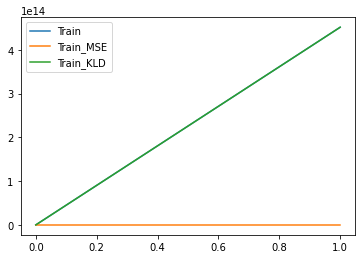

In [35]:
import matplotlib.pyplot as plt
plt.plot(train_losses)
plt.plot(train_losses_MSE)
plt.plot(train_losses_KLD)
plt.legend(['Train', 'Train_MSE', 'Train_KLD'])

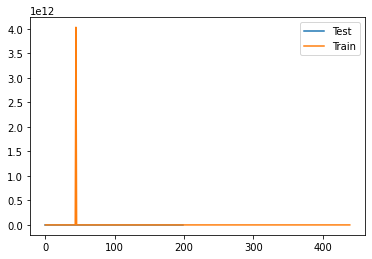

In [16]:
import matplotlib.pyplot as plt
plt.plot(test_losses)
plt.plot(train_losses)
plt.legend(['Test', 'Train'])

### Draw random samples form latent space and generate new data

In [19]:
var2 = []
for batch_idx, data in enumerate(testloader):
    var2 = data
    break

decodeOutput(var2)

[       amount  unit       ingredient
 0   1.9716426  gram  white_chocolate
 1   1.6963401  gram        margarine
 2    5.094402  gram     golden_syrup
 3   3.2500005  gram         krispies
 4   2.2216258  gram      rolled_oats
 5   2.3697906  gram   dried_apricots
 6   1.5442302  gram          walnuts
 7         0.0                       
 8         0.0                       
 9         0.0                       
 10        0.0                       
 11        0.0                       
 12        0.0                       
 13        0.0                       
 14        0.0                       
 15        0.0                       
 16        0.0                       
 17        0.0                       
 18        0.0                       
 19        0.0                       ,
           amount        unit             ingredient
 0    0.019716427              chicken_breast_halves
 1    0.003731948         cup        parmesan_cheese
 2     0.10188804  tablespoon          fre

In [17]:
var = []
with torch.no_grad():
    for batch_idx, data in enumerate(testloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        var = decodeOutput(recon_batch)
        break

var

[           amount        unit        ingredient
 0    7.932988e-05                       lengths
 1    0.0001049446                      Prosecco
 2    9.782505e-05              coffee_ice_cubes
 3   0.00010406457         cup          stirring
 4   5.1169496e-05                      hangover
 5      8.8303e-05                       thimble
 6    8.813811e-05    teaspoon                  
 7   8.7606444e-05    teaspoon                  
 8    6.207476e-05                              
 9    9.326476e-05         cup                  
 10   8.645025e-05        drop                  
 11  0.00010763657         cup                  
 12  0.00037035285         cup                  
 13  8.2085106e-05  tablespoon                  
 14  4.6966674e-05         cup                  
 15   7.099713e-05  pound-mass                  
 16   0.0012703852         cup                  
 17  0.00010671015    teaspoon                  
 18  0.00016552898  tablespoon                  
 19   0.0008797583  

In [15]:
sigma = torch.exp(logvar/2)
# sample z from q
no_samples = 20
q = torch.distributions.Normal(mu.mean(axis=0), sigma.mean(axis=0))
z = q.rsample(sample_shape=torch.Size([no_samples]))

In [16]:
scaler = trainloader.dataset.standardizer

with torch.no_grad():
    pred = model.decode(z).cpu().numpy()

fake_data = scaler.inverse_transform(pred)
df_fake = pd.DataFrame(fake_data)

In [25]:
df_fake

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,6320,6321,6322,6323,6324,6325,6326,6327,6328,6329,6330,6331,6332,6333,6334,6335,6336,6337,6338,6339,6340,6341,6342,6343,6344,6345,6346,6347,6348,6349,6350,6351,6352,6353,6354,6355,6356,6357,6358,6359
0,14.512605,4.150554,4.859861,5.566523,4.321220,3.545336,4.467539,2.668230,2.312032,1.499787,1.401830,1.233157,0.589990,0.565626,0.239487,0.259716,0.257413,0.072627,0.046913,0.011221,0.326206,0.094178,0.015845,0.236584,0.086335,0.128151,0.004871,0.026623,0.006948,0.000126,0.000823,0.009793,0.003424,0.000059,0.001940,0.001829,0.000293,0.291931,0.169116,0.100445,...,0.005599,5.006762e-08,4.653808e-08,0.001809,0.006123,3.016358e-08,0.007187,3.456380e-08,0.005183,3.917945e-08,5.261472e-08,0.006337,0.00441,5.005087e-08,0.007055,4.310293e-08,7.202773e-08,0.005048,5.602485e-08,6.474716e-08,0.007296,0.004929,0.003833,0.007261,0.006459,0.006476,0.004499,6.085416e-08,0.004538,3.583685e-08,3.400954e-08,0.004602,0.003997,2.936430e-08,0.006073,7.303775e-08,2.928825e-08,3.557906e-08,2.772707e-08,0.005515
1,19.615408,5.227788,5.794825,6.786532,2.070865,3.090663,1.831093,2.294748,1.736958,1.196863,0.845446,0.631848,0.879981,0.524690,0.167331,0.364202,0.204332,0.058573,0.010254,0.005676,0.333559,0.060722,0.012348,0.296739,0.082305,0.139774,0.002465,0.024282,0.002579,0.000025,0.000792,0.009694,0.003006,0.000035,0.002074,0.000673,0.000149,0.285475,0.153541,0.091848,...,0.005600,3.775737e-09,3.727245e-09,0.002120,0.006124,8.199874e-09,0.007187,1.842477e-09,0.005183,4.264536e-09,3.638455e-09,0.006337,0.00441,3.563941e-09,0.007055,3.582148e-09,3.934061e-09,0.005048,6.633026e-09,4.856578e-09,0.007296,0.004929,0.003833,0.007261,0.006459,0.006476,0.004499,6.906440e-09,0.004538,2.347504e-09,6.230937e-09,0.004602,0.003997,3.386121e-09,0.006073,6.037995e-09,1.891641e-09,2.036618e-09,1.889600e-09,0.005515
2,14.984136,6.721791,7.208185,5.470522,3.162135,4.095630,2.690613,2.109186,1.756295,2.990574,1.071832,0.773598,0.899151,0.937155,0.245380,0.205590,0.188587,0.082032,0.017928,0.013303,0.336075,0.076024,0.014641,0.269251,0.112736,0.133794,0.002260,0.036368,0.003710,0.000062,0.001994,0.010888,0.006763,0.000074,0.003128,0.001114,0.000248,0.266710,0.157046,0.083028,...,0.005600,1.867162e-08,1.224869e-08,0.002004,0.006124,3.520588e-08,0.007187,6.535917e-09,0.005183,2.104120e-08,1.367302e-08,0.006337,0.00441,2.908997e-08,0.007055,2.074171e-08,1.671842e-08,0.005048,3.061281e-08,1.999867e-08,0.007296,0.004929,0.003833,0.007261,0.006459,0.006476,0.004499,3.142195e-08,0.004538,2.476011e-08,2.506931e-08,0.004602,0.003997,1.039867e-08,0.006073,2.477677e-08,1.086370e-08,1.596070e-08,9.471281e-09,0.005515
3,12.379004,6.318147,7.965633,3.946486,5.460772,2.739715,3.283463,3.362578,1.900427,1.074762,1.122560,0.619972,0.481463,0.494882,0.234237,0.246402,0.190696,0.056725,0.053340,0.017784,0.287641,0.086527,0.024281,0.246194,0.143126,0.137226,0.003574,0.026323,0.005732,0.000098,0.000987,0.016072,0.007480,0.000041,0.002248,0.002636,0.000328,0.263504,0.171719,0.098015,...,0.005599,4.669952e-08,3.578195e-08,0.001801,0.006123,3.674360e-08,0.007187,1.780124e-08,0.005183,3.898370e-08,6.466082e-08,0.006337,0.00441,2.820564e-08,0.007055,3.936568e-08,3.803398e-08,0.005048,5.531209e-08,2.713861e-08,0.007296,0.004929,0.003833,0.007261,0.006459,0.006476,0.004499,3.602879e-08,0.004538,6.830924e-08,4.459074e-08,0.004602,0.003997,4.214022e-08,0.006073,7.292006e-08,3.654353e-08,2.448314e-08,4.141713e-08,0.005515
4,8.969606,6.268566,3.877958,5.478240,4.550981,3.575338,2.344465,2.505691,2.322191,2.395511,1.042833,0.654805,0.340078,0.262572,0.164511,0.061177,0.153286,0.041591,0.037559,0.030330,0.292686,0.093896,0.014108,0.304994,0.125151,0.122978,0.004304,0.025594,0.006495,0.000112,0.001413,0.014944,0.006039,0.000048,0.002440,0.001372,0.000286,0.260498,0.168331,0.056724,...,0.005600,6.297889e-08,4.356402e-08,0.001688,0.006123,2.282631e-08,0.007187,1.587615e-08,0.005183,4.436830e-08,4

In [17]:
print(fake_data.shape)
print(type(fake_data))

(20, 6360)
<class 'numpy.ndarray'>


In [14]:
def inverseOneHotEncoding(encoded: np.ndarray, dictionary: dict) -> np.ndarray:
    output = []
    for row in encoded:
        rowTransformed = np.reshape(row, (20,-1))
        rowString = []
        indexTransformed = np.argmax(rowTransformed, axis=1) + 1
        for index in indexTransformed:
            if (index in dictionary.values()):
                rowString.append(list(dictionary.keys())[list(dictionary.values()).index(index)])
            else:
                rowString.append("")
        output.append(rowString)
    return np.array(output)

In [15]:
def inverseEmbedding(embedded: np.ndarray, dictionary: dict) -> np.ndarray:
    output = []
    for row in embedded:
        outputRows = []
        for rowTransformed in np.reshape(row, (20,-1)):
            rowTransformed = torch.Tensor(rowTransformed)
            distance = torch.norm(preprocessor.emb.weight.data - rowTransformed, dim=1)
            nearest = torch.argmin(distance)
            index = nearest.item()
            if index:
                outputRows.append(list(dictionary.keys())[list(dictionary.values()).index(index)])
            else:
                outputRows.append("")
        output.append(outputRows)

    return np.array(output)

In [16]:
def decodeOutput(output: np.ndarray):
    # Split output into amounts, units and ingredients 
    amounts = output[:, :20]
    amountColumns = ['amount_' + str(sub) for sub in list(range(0,20))]
    units = output[:, 20:len(preprocessor.unitDict)*20+20]
    unitColumns = ['unit_' + str(sub) for sub in list(range(0,20))]
    ingredients = output[:, len(preprocessor.unitDict)*20+20:]
    ingredientColumns = ['ingredient_' + str(sub) for sub in list(range(0,20))]
    unitsDecoded = inverseOneHotEncoding(units, preprocessor.unitDict)
    ingredientsDecoded = inverseEmbedding(ingredients, preprocessor.ingredientDict)
    outputFrame = []
    for index in range(len(amounts)):
        array = np.stack((amounts[index], unitsDecoded[index], ingredientsDecoded[index]),axis=1)
        outputFrame.append(pd.DataFrame(array, columns=["amount", "unit", "ingredient"]))
    return outputFrame

df = decodeOutput(fake_data)
df[0]

NameError: name 'fake_data' is not defined

In [77]:
data = pklData[:1]['ingredients']

dataEmbedded = np.array(preprocessor.preProcessInput(data))

y, mu, logvar = model(dataEmbedded)


dataReconverted = decodeOutput(dataEmbedded)
pd.concat([dataReconverted[0], data[0].add_prefix("orig_")], axis=1)

TypeError: linear(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

In [22]:
string = "dry dill weed"
name_words = string.lower().split(' ')
for i in range(len(name_words)):
    print('_'.join(name_words[i:]))

dry_dill_weed
dill_weed
weed


In [23]:
embeddings = torch.nn.Embedding(1000, 100)
my_sample = torch.randn(1, 100)
distance = torch.norm(embeddings.weight.data - my_sample, dim=1)
nearest = torch.argmin(distance)
print(my_sample.shape)
print(embeddings.weight.data.shape)

torch.Size([1, 100])
torch.Size([1000, 100])


In [24]:
df_fake_stripped = df_fake.drop(columns=dropColumns)
df_fake_stripped_decoded = pd.DataFrame(data=enc.inverse_transform(df_fake_stripped), columns=frameStripped_cols)
df_fake_decoded = pd.concat([df_fake[dropColumns], df_fake_stripped_decoded], axis=1)
df_fake_decoded

NameError: ignored

In [ ]:
class Ingredient:
    def __init__(self, amount, unit, ingredient) -> None:
        self.amount = amount
        self.unit = unit
        self.ingredient = ingredient

    def __repr__(self) -> str:
        return "\nAmount: " + str(self.amount) + "\n Unit: " + str(self.unit) + "\n Ingredient: " + str(self.ingredient)

recipes = []
lenIngredients = int(len(df_fake_decoded.columns)/3)
for value in df_fake_decoded.values:
    ingredients = []
    for index in range(0,lenIngredients):
        frame = []
        frame.append(value[index])
        frame.append(value[(2*index)+lenIngredients])
        frame.append(value[(2*index+1)+lenIngredients])
        ingredients.append(frame)
    recipes.append(ingredients)

pd.DataFrame(recipes)